#### Notebook to analyze realtor.com dataset, and create pre and post covid dataframes

realtor data sourced from: https://www.realtor.com/research/data.

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit as curve_fit
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('realtor_clean.csv')

In [3]:
def add_year(df):
    """ Add Year column"""
    if 'Year' not in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])

def linear(x, m, b):
    return m*x + b

add_year(df)

In [4]:
pre_covid_realtor = df[df['Date'] < '2020-03-01']
post_covid_realtor = df[df['Date'] >= '2020-03-01']

In [5]:
pre_covid_realtor = df[df['Date'] < '2020-03-01']
post_covid_realtor = df[df['Date'] >= '2020-03-01']
post_covid_realtor

,month_date_yyyymm,postal_code,average_listing_price,Date
0,202111,94109,2.226320e+06,2021-11-01
1,202111,94111,1.308000e+06,2021-11-01
2,202111,94102,9.861155e+05,2021-11-01
3,202111,94110,1.485246e+06,2021-11-01
4,202111,94133,2.217766e+06,2021-11-01
...,...,...,...,...
508,202003,94111,1.601897e+06,2020-03-01
509,202003,94121,2.372981e+06,2020-03-01
510,202003,94109,2.690649e+06,2020-03-01
511,202003,94132,1.591372e+06,2020-03-01


In [6]:
perc_change = []
df = post_covid_realtor
for zipcode in (np.unique(df['postal_code'])):
    first = min(df[df['postal_code'] == zipcode]['Date'])
    last = max(df[df['postal_code'] == zipcode]['Date'])
    zip_df = df[df['postal_code'] == zipcode]
    first = int(zip_df.loc[zip_df['Date'] == first]['average_listing_price'])
    last = int(zip_df.loc[zip_df['Date'] == last]['average_listing_price'])
    perc_change.append((last - first)/first * 100)
perc_change = pd.DataFrame({'postal_code':np.unique(df['postal_code']), 'percent_change':perc_change})
perc_change.to_csv('post_covid_realtor_perc_change_df.csv')

In [7]:
df = post_covid_realtor
lin_df = df.groupby(['postal_code', 'Date']).sum().unstack(level=0)['average_listing_price']

#### Fit a line to median listing price vs. time for each zipcode  

In [8]:
m_arr = []
b_arr = []
m_err_arr = []
b_err_arr = []
for col in lin_df.columns:
    temp = lin_df[col].dropna()
    temp.index = pd.to_datetime(temp.index)
    temp.index = temp.index.map(dt.datetime.toordinal)
    x = list(temp.index)
    y = temp.values
    popt, pcov = curve_fit(linear, x, y)
    perr = np.sqrt(np.diag(pcov))
    m, b = popt
    m_arr.append(m)
    b_arr.append(b)
    m_err_arr.append(perr[0])
    b_err_arr.append(perr[1])

fit_df = pd.DataFrame({'postal_code':lin_df.columns, 'slope($_per_month)':m_arr, 'intercept':b_arr,
                      'slope_err':m_err_arr, 'intercept_err':b_err_arr})
fit_df.to_csv("post_covid_realtor_rate_change.csv")

In [9]:
fit_df = pd.DataFrame({'postal_code':lin_df.columns, 'slope($_per_month)':m_arr, 'intercept':b_arr,
                      'slope_err':m_err_arr, 'intercept_err':b_err_arr})
fit_df.to_csv("post_covid_realtor_rate_change.csv")

#### Look at one zipcode

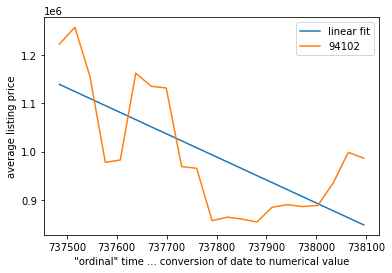

In [10]:
lin_df = df.groupby(['postal_code', 'Date']).sum().unstack(level=0)['average_listing_price']

temp = lin_df[94102]
temp.index = pd.to_datetime(temp.index)
temp.index = temp.index.map(dt.datetime.toordinal)

m = float(fit_df.loc[fit_df['postal_code'] == 94102]['slope($_per_month)'])
b = float(fit_df.loc[fit_df['postal_code'] == 94102]['intercept'])
plt.plot(temp.index, linear(temp.index, m, b), label='linear fit')
plt.plot(temp.index, temp.values, label='94102')
plt.xlabel(' \"ordinal" time ... conversion of date to numerical value ')
plt.ylabel('average listing price')
plt.legend()

In [11]:
fit_df.to_csv('realtor_data_fitted_vals.csv')